In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Active device:", device)

Active device: cpu


In [ ]:
import os

HOME = os.getcwd()
print(HOME)

# Installing Grounding DINO

%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO
!pip install -q -e .
!pip install supervision

# Download Weights

!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

# Load Model

%cd {HOME}/GroundingDINO
from groundingdino.util.inference import load_model, load_image, predict, annotate

model = load_model(f"{HOME}/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py",
                   f"{HOME}/weights/groundingdino_swint_ogc.pth")

model.to(device)

/content
/content
fatal: destination path 'GroundingDINO' already exists and is not an empty directory.
/content/GroundingDINO
  Preparing metadata (setup.py) ... done
mkdir: cannot create directory ‘/content/weights’: File exists
/content/weights
/content/GroundingDINO


final text_encoder_type: bert-base-uncased


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


GroundingDINO(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x DeformableTransformerEncoderLayer(
          (self_attn): MultiScaleDeformableAttention(
            (sampling_offsets): Linear(in_features=256, out_features=256, bias=True)
            (attention_weights): Linear(in_features=256, out_features=128, bias=True)
            (value_proj): Linear(in_features=256, out_features=256, bias=True)
            (output_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (dropout1): Dropout(p=0.0, inplace=False)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout2): Dropout(p=0.0, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (dropout3): Dropout(p=0.0, inplace=False)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_aff

In [ ]:
import os

folder_path = '/content/SeparateJSON'

# Create the folder if it doesn't exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


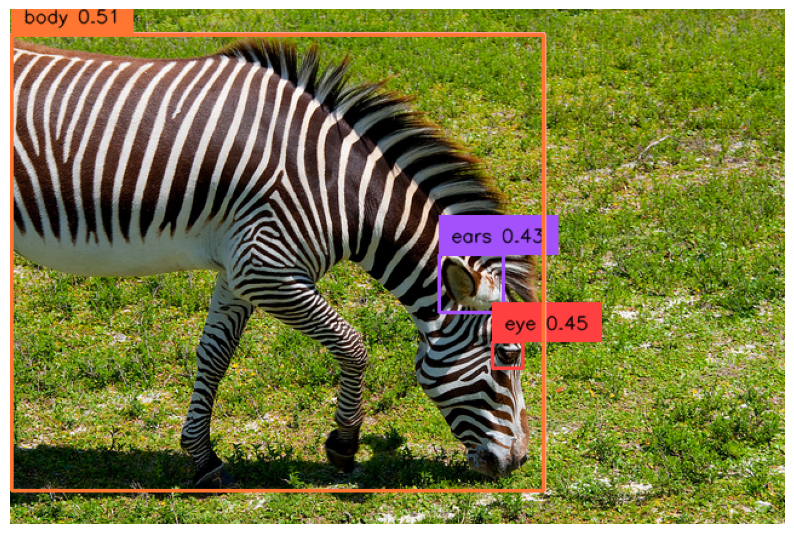

{
    "images": [
        {
            "id": 34,
            "coco_url": "https://images.cocodataset.org/val2014/000000000034.jpg",
            "width": 800,
            "height": 1204,
            "file_name": "000000000034.jpg"
        }
    ],
    "annotations": [
        {
            "id": 1,
            "image_id": 34,
            "category_id": 1,
            "bbox": [
                0.5954540371894836,
                0.5336087942123413,
                0.08185083419084549,
                0.11342602968215942
            ],
            "area": 0.21580721370752398,
            "iscrowd": 0,
            "score": 0.4253479540348053
        },
        {
            "id": 2,
            "image_id": 34,
            "category_id": 2,
            "bbox": [
                0.6423879861831665,
                0.6716530919075012,
                0.038589008152484894,
                0.05030011013150215
            ],
            "area": 0.37517229539266495,
            "iscrowd": 0,
   

In [ ]:
import os
import supervision as sv
import json
import torch

IMAGE_NAME = "000000000034.jpg"
IMAGE_PATH = os.path.join(HOME, "/content/drive/MyDrive/Images", IMAGE_NAME)

TEXT_PROMPT = "part of body, eye, ears"
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

image_source, image = load_image(IMAGE_PATH)

boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD,
    device=device
)

boxes = boxes.cpu().tolist()
logits = logits.cpu().tolist()

annotated_frame = annotate(image_source=image_source, boxes=torch.tensor(boxes), logits=torch.tensor(logits), phrases=phrases)
# Visualize result

%matplotlib inline
sv.plot_image(annotated_frame, (10, 10))

# Define the COCO annotations format

image_id = int(IMAGE_NAME.replace(".jpg", ""))
images = {
    "id": image_id,
    "coco_url": "https://images.cocodataset.org/val2014/" + IMAGE_NAME,
    "width": image.shape[1],
    "height": image.shape[2],
    "file_name": IMAGE_NAME
}

annotations = []
for i, (box, logit, phrase) in enumerate(zip(boxes, logits, phrases)):
    x_min, y_min, x_max, y_max = box
    area = (x_max - x_min) * (y_max - y_min)
    annotation = {
        "id": i + 1,
        "image_id": image_id,
        "category_id": i + 1,
        "bbox": box,
        "area": area,
        "iscrowd": 0,
        "score": float(logit)
    }
    annotations.append(annotation)

categories = [{"id": i + 1, "name": phrase} for i, phrase in enumerate(phrases)]

data = {
    "images": [images],
    "annotations": annotations,
    "categories": categories
}

# Save to a separate JSON file
output_file = os.path.join(HOME, f"SeparateJSON/{image_id}.json")
with open(output_file, 'w') as f:
    json.dump(data, f, indent=4)

print(json.dumps(data, indent=4))

output_file = os.path.join(HOME, "coco_annotations.json")
if os.path.exists(output_file):
    with open(output_file, 'r') as f:
        existing_data = json.load(f)
else:
    existing_data = {"images": [], "annotations": [], "categories": []}

# Update existing data with new data
existing_data["images"].append(images)
existing_data["annotations"].extend(annotations)
existing_data["categories"].extend(categories)

# Save the updated data
with open(output_file, 'w') as f:
    json.dump(existing_data, f, indent=4)


SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


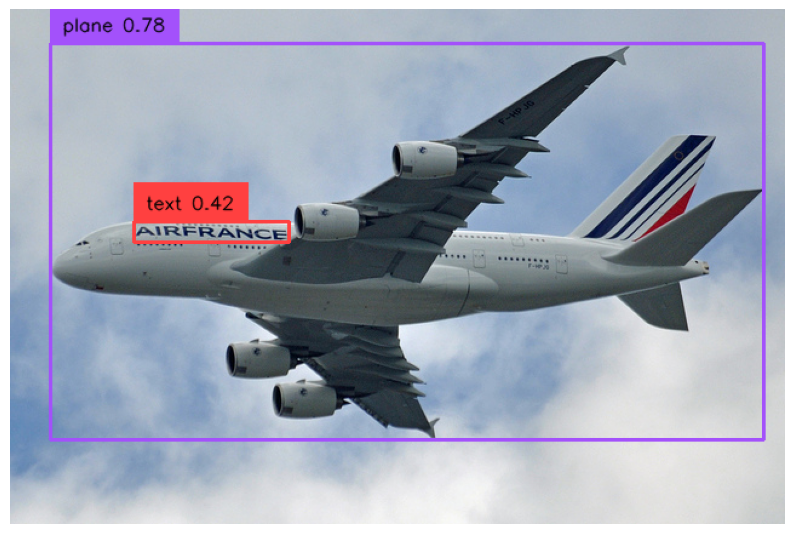

{
    "images": [
        {
            "id": 81,
            "coco_url": "https://images.cocodataset.org/val2014/000000000081.jpg",
            "width": 800,
            "height": 1204,
            "file_name": "000000000081.jpg"
        }
    ],
    "annotations": [
        {
            "id": 1,
            "image_id": 81,
            "category_id": 1,
            "bbox": [
                0.5125350952148438,
                0.45240506529808044,
                0.9213986992835999,
                0.7686387896537781
            ],
            "area": 0.1292964602681561,
            "iscrowd": 0,
            "score": 0.776332437992096
        },
        {
            "id": 2,
            "image_id": 81,
            "category_id": 2,
            "bbox": [
                0.25976359844207764,
                0.4322472810745239,
                0.20039449632167816,
                0.04007197543978691
            ],
            "area": 0.023283095769327578,
            "iscrowd": 0,
     

In [ ]:
import os
import supervision as sv
import json
import torch

IMAGE_NAME = "000000000081.jpg"
IMAGE_PATH = os.path.join(HOME, "/content/drive/MyDrive/Images", IMAGE_NAME)

TEXT_PROMPT = "Text, plane"
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

image_source, image = load_image(IMAGE_PATH)

boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD,
    device=device
)

boxes = boxes.cpu().tolist()
logits = logits.cpu().tolist()

annotated_frame = annotate(image_source=image_source, boxes=torch.tensor(boxes), logits=torch.tensor(logits), phrases=phrases)

# Visualize result

%matplotlib inline
sv.plot_image(annotated_frame, (10, 10))

# Define the COCO annotations format

image_id = int(IMAGE_NAME.replace(".jpg", ""))
images = {
    "id": image_id,
    "coco_url": "https://images.cocodataset.org/val2014/" + IMAGE_NAME,
    "width": image.shape[1],
    "height": image.shape[2],
    "file_name": IMAGE_NAME
}

annotations = []
for i, (box, logit, phrase) in enumerate(zip(boxes, logits, phrases)):
    x_min, y_min, x_max, y_max = box
    area = (x_max - x_min) * (y_max - y_min)
    annotation = {
        "id": i + 1,
        "image_id": image_id,
        "category_id": i + 1,
        "bbox": box,
        "area": area,
        "iscrowd": 0,
        "score": float(logit)
    }
    annotations.append(annotation)

categories = [{"id": i + 1, "name": phrase} for i, phrase in enumerate(phrases)]

data = {
    "images": [images],
    "annotations": annotations,
    "categories": categories
}

# Save to a separate JSON file
output_file = os.path.join(HOME, f"SeparateJSON/{image_id}.json")
with open(output_file, 'w') as f:
    json.dump(data, f, indent=4)

print(json.dumps(data, indent=4))

output_file = os.path.join(HOME, "coco_annotations.json")
if os.path.exists(output_file):
    with open(output_file, 'r') as f:
        existing_data = json.load(f)
else:
    existing_data = {"images": [], "annotations": [], "categories": []}

# Update existing data with new data
existing_data["images"].append(images)
existing_data["annotations"].extend(annotations)
existing_data["categories"].extend(categories)

# Save the updated data
with open(output_file, 'w') as f:
    json.dump(existing_data, f, indent=4)

SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


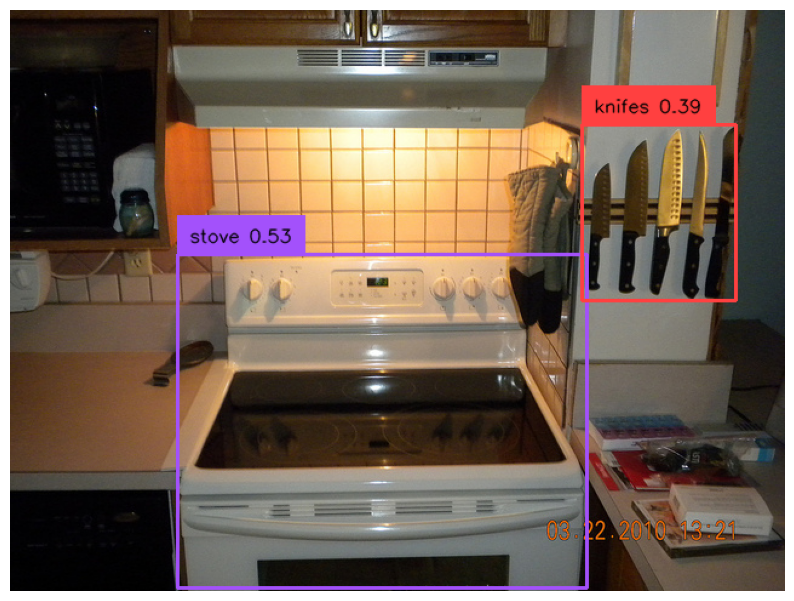

{
    "images": [
        {
            "id": 89,
            "coco_url": "https://images.cocodataset.org/val2014/000000000089.jpg",
            "width": 800,
            "height": 1066,
            "file_name": "000000000089.jpg"
        }
    ],
    "annotations": [
        {
            "id": 1,
            "image_id": 89,
            "category_id": 1,
            "bbox": [
                0.4806235730648041,
                0.7084896564483643,
                0.5292381048202515,
                0.5725632309913635
            ],
            "area": -0.006607999526783814,
            "iscrowd": 0,
            "score": 0.5258631706237793
        },
        {
            "id": 2,
            "image_id": 89,
            "category_id": 2,
            "bbox": [
                0.8374292850494385,
                0.3493364453315735,
                0.19931648671627045,
                0.3015178442001343
            ],
            "area": 0.03051366138036027,
            "iscrowd": 0,
     

In [ ]:
import os
import supervision as sv
import json
import torch

IMAGE_NAME = "000000000089.jpg"
IMAGE_PATH = os.path.join(HOME, "/content/drive/MyDrive/Images", IMAGE_NAME)

TEXT_PROMPT = "Knifes, Stove"
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

image_source, image = load_image(IMAGE_PATH)

boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD,
    device=device
)

boxes = boxes.cpu().tolist()
logits = logits.cpu().tolist()

annotated_frame = annotate(image_source=image_source, boxes=torch.tensor(boxes), logits=torch.tensor(logits), phrases=phrases)

# Visualize result

%matplotlib inline
sv.plot_image(annotated_frame, (10, 10))

# Define the COCO annotations format

image_id = int(IMAGE_NAME.replace(".jpg", ""))
images = {
    "id": image_id,
    "coco_url": "https://images.cocodataset.org/val2014/" + IMAGE_NAME,
    "width": image.shape[1],
    "height": image.shape[2],
    "file_name": IMAGE_NAME
}

annotations = []
for i, (box, logit, phrase) in enumerate(zip(boxes, logits, phrases)):
    x_min, y_min, x_max, y_max = box
    area = (x_max - x_min) * (y_max - y_min)
    annotation = {
        "id": i + 1,
        "image_id": image_id,
        "category_id": i + 1,
        "bbox": box,
        "area": area,
        "iscrowd": 0,
        "score": float(logit)
    }
    annotations.append(annotation)

categories = [{"id": i + 1, "name": phrase} for i, phrase in enumerate(phrases)]

data = {
    "images": [images],
    "annotations": annotations,
    "categories": categories
}

# Save to a separate JSON file
output_file = os.path.join(HOME, f"SeparateJSON/{image_id}.json")
with open(output_file, 'w') as f:
    json.dump(data, f, indent=4)

print(json.dumps(data, indent=4))

output_file = os.path.join(HOME, "coco_annotations.json")
if os.path.exists(output_file):
    with open(output_file, 'r') as f:
        existing_data = json.load(f)
else:
    existing_data = {"images": [], "annotations": [], "categories": []}

# Update existing data with new data
existing_data["images"].append(images)
existing_data["annotations"].extend(annotations)
existing_data["categories"].extend(categories)

# Save the updated data
with open(output_file, 'w') as f:
    json.dump(existing_data, f, indent=4)

SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


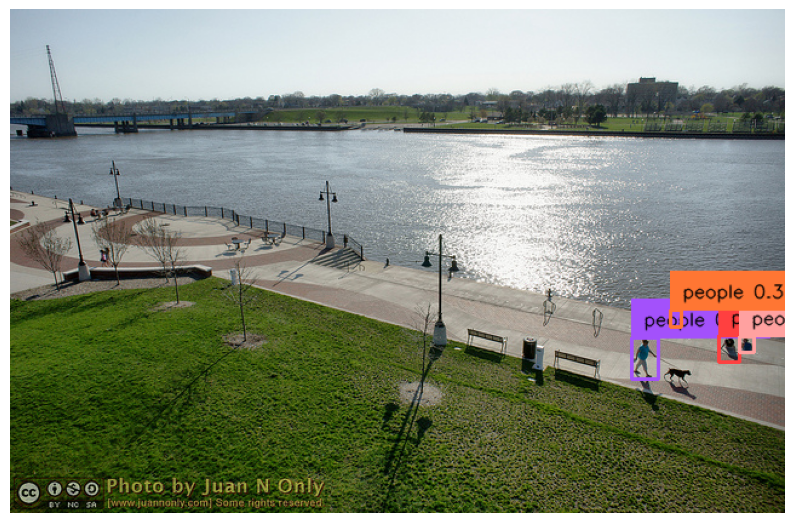

{
    "images": [
        {
            "id": 109,
            "coco_url": "https://images.cocodataset.org/val2014/000000000109.jpg",
            "width": 800,
            "height": 1230,
            "file_name": "000000000109.jpg"
        }
    ],
    "annotations": [
        {
            "id": 1,
            "image_id": 109,
            "category_id": 1,
            "bbox": [
                0.8190300464630127,
                0.692846417427063,
                0.034166138619184494,
                0.08157043159008026
            ],
            "area": 0.47976845901510284,
            "iscrowd": 0,
            "score": 0.62105792760849
        },
        {
            "id": 2,
            "image_id": 109,
            "category_id": 2,
            "bbox": [
                0.9283633828163147,
                0.6738190650939941,
                0.027004428207874298,
                0.05434003844857216
            ],
            "area": 0.5583729678589717,
            "iscrowd": 0,
   

In [ ]:
import os
import supervision as sv
import json
import torch

IMAGE_NAME = "000000000109.jpg"
IMAGE_PATH = os.path.join(HOME, "/content/drive/MyDrive/Images", IMAGE_NAME)

TEXT_PROMPT = "People"
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

image_source, image = load_image(IMAGE_PATH)

boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD,
    device=device
)

boxes = boxes.cpu().tolist()
logits = logits.cpu().tolist()

annotated_frame = annotate(image_source=image_source, boxes=torch.tensor(boxes), logits=torch.tensor(logits), phrases=phrases)

# Visualize result

%matplotlib inline
sv.plot_image(annotated_frame, (10, 10))

# Define the COCO annotations format

image_id = int(IMAGE_NAME.replace(".jpg", ""))
images = {
    "id": image_id,
    "coco_url": "https://images.cocodataset.org/val2014/" + IMAGE_NAME,
    "width": image.shape[1],
    "height": image.shape[2],
    "file_name": IMAGE_NAME
}

annotations = []
for i, (box, logit, phrase) in enumerate(zip(boxes, logits, phrases)):
    x_min, y_min, x_max, y_max = box
    area = (x_max - x_min) * (y_max - y_min)
    annotation = {
        "id": i + 1,
        "image_id": image_id,
        "category_id": i + 1,
        "bbox": box,
        "area": area,
        "iscrowd": 0,
        "score": float(logit)
    }
    annotations.append(annotation)

categories = [{"id": i + 1, "name": phrase} for i, phrase in enumerate(phrases)]

data = {
    "images": [images],
    "annotations": annotations,
    "categories": categories
}

# Save to a separate JSON file
output_file = os.path.join(HOME, f"SeparateJSON/{image_id}.json")
with open(output_file, 'w') as f:
    json.dump(data, f, indent=4)

print(json.dumps(data, indent=4))

output_file = os.path.join(HOME, "coco_annotations.json")
if os.path.exists(output_file):
    with open(output_file, 'r') as f:
        existing_data = json.load(f)
else:
    existing_data = {"images": [], "annotations": [], "categories": []}

# Update existing data with new data
existing_data["images"].append(images)
existing_data["annotations"].extend(annotations)
existing_data["categories"].extend(categories)

# Save the updated data
with open(output_file, 'w') as f:
    json.dump(existing_data, f, indent=4)

In [ ]:
with open("/content/coco_annotations.json", 'r') as f:
    data = json.load(f)

# Print all data
print(json.dumps(data, indent=4))

{
    "images": [
        {
            "id": 34,
            "coco_url": "https://images.cocodataset.org/val2014/000000000034.jpg",
            "width": 800,
            "height": 1204,
            "file_name": "000000000034.jpg"
        },
        {
            "id": 81,
            "coco_url": "https://images.cocodataset.org/val2014/000000000081.jpg",
            "width": 800,
            "height": 1204,
            "file_name": "000000000081.jpg"
        },
        {
            "id": 89,
            "coco_url": "https://images.cocodataset.org/val2014/000000000089.jpg",
            "width": 800,
            "height": 1066,
            "file_name": "000000000089.jpg"
        },
        {
            "id": 109,
            "coco_url": "https://images.cocodataset.org/val2014/000000000109.jpg",
            "width": 800,
            "height": 1230,
            "file_name": "000000000109.jpg"
        }
    ],
    "annotations": [
        {
            "id": 1,
            "image_id": 34,